## Problem Statement

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim of this data science project is to build a predictive model and find out the sales of each product at a particular store.

## Loading Packages and Data

In [382]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

In [383]:
train_data = pd.read_csv('Train.csv')

## Data Structure and Content

In [384]:
train_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [385]:
print("The train data has {} rows and {} columns".format(train_data.shape[0],train_data.shape[1]))

The train data has 8523 rows and 12 columns


In [386]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [387]:
train_data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [388]:
train_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


C:\Users\mahmo\AppData\Local\Temp\ipykernel_20380\1024995339.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_data.corr(), annot=True, cmap='cubehelix_r')


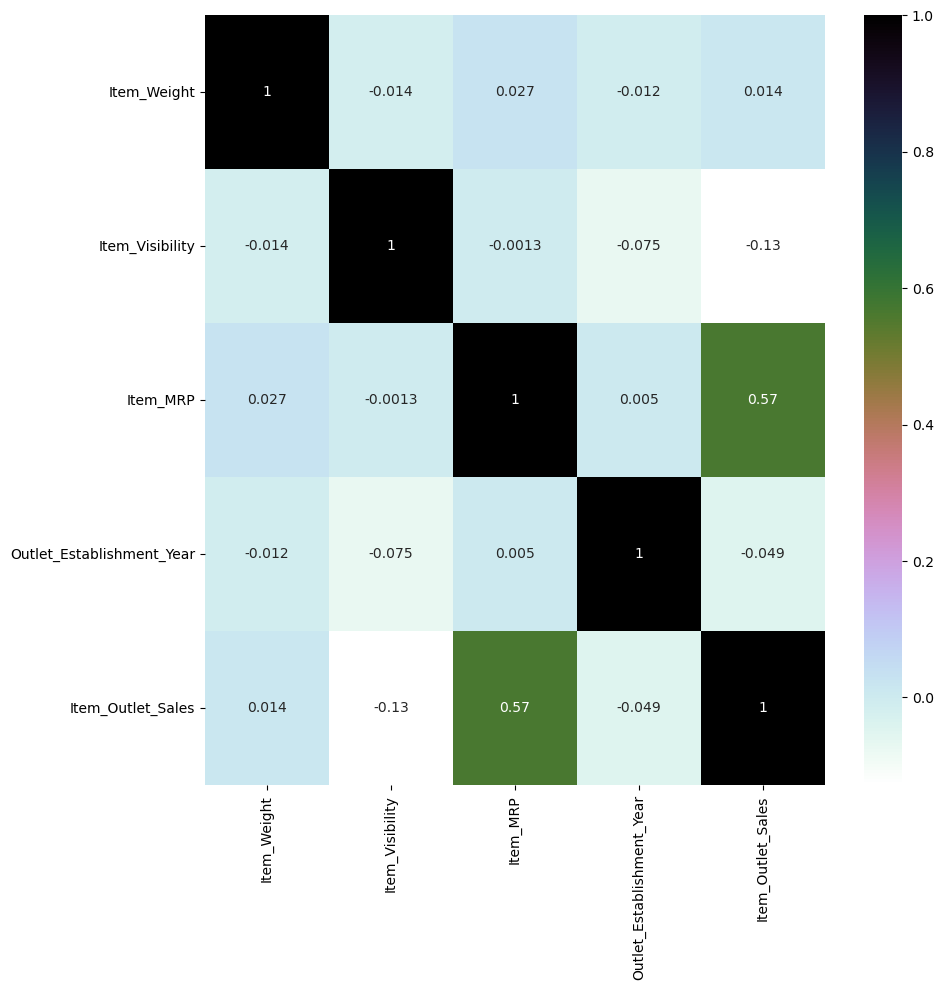

In [389]:
plt.figure(figsize=(10,10))
sns.heatmap(train_data.corr(), annot=True, cmap='cubehelix_r')
plt.show()

From the correlation above we can see that Item_MRP has a positive correlation with Item_Outlet_Sales. This indicates that the price of the product plays a vital role in increasing sales. Also, Item_Visibility has a negative correlation with Item_Outlet_Sales which means that if the product is more visible to the customers, it sells more. Similarly, we can analyze all the other variables and come up with some insights.

## Univariate Analysis

We will visualize the data to see the relationship between different variables and and identify the distribution of values in categorical variables.

#### Helper Visualization Class

In [390]:
class HistogramPlotter():
    def __init__(self):
        pass

    def plot_countplot(self, data, column_name, title, xlabel, ylabel):
        """
        This function plots a countplot for a given column in a given data frame

        Parameters:
        data (dataframe): the dataframe to be used
        column_name (string): the name of the column to be plotted
        title (string): the title of the plot
        xlabel (string): the label of the x axis
        ylabel (string): the label of the y axis

        Returns:
        None
        """
        plt.title(title)
        sns.countplot(data=data, x=column_name)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

    def plot_countplot_horizontal(self, data, column_name, title, xlabel, ylabel):
        """
        This function plots a countplot for a given column in a given data frame

        Parameters:
        data (dataframe): the dataframe to be used
        column_name (string): the name of the column to be plotted
        title (string): the title of the plot
        xlabel (string): the label of the x axis
        ylabel (string): the label of the y axis

        Returns:
        None
        """
        plt.title(title)
        sns.countplot(data=data, y=column_name, order = data[column_name].value_counts().index)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()
    
    def plot_displot(self, data, column_name, title, xlabel, ylabel):
        """
        This function plots a displot for a given column in a given data frame

        Parameters:
        data (dataframe): the dataframe to be used
        column_name (string): the name of the column to be plotted
        title (string): the title of the plot
        xlabel (string): the label of the x axis
        ylabel (string): the label of the y axis

        Returns:
        None
        """
        sns.displot(data[column_name], color='r', label='Skewness : %.2f'%(data[column_name].skew()), kde=True)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.show()

In [391]:
plotter = HistogramPlotter()

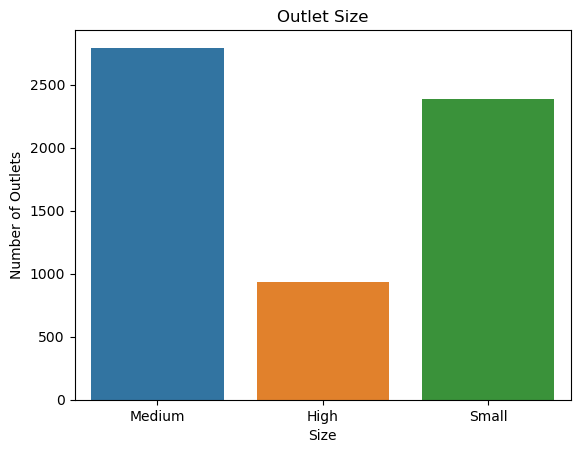

In [392]:
plotter.plot_countplot(train_data, 'Outlet_Size', 'Outlet Size', 'Size', 'Number of Outlets')

From above we can see that number of outlets with size High is the smallest, small and medium outlets are almost equal in number.

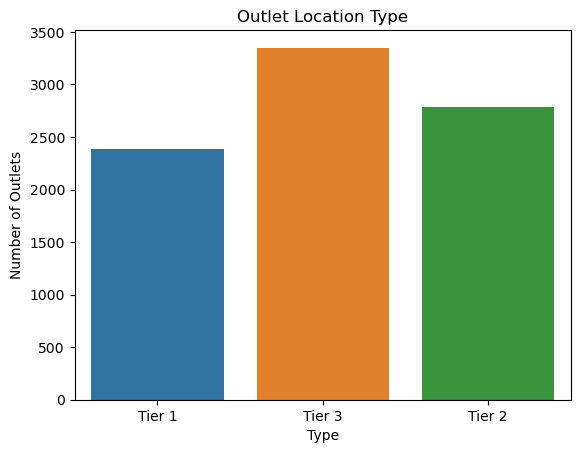

In [393]:
plotter.plot_countplot(train_data, 'Outlet_Location_Type', 'Outlet Location Type', 'Type', 'Number of Outlets')

From the above plot, we can see that most of items are sell in outlets that are located in Tier 3.

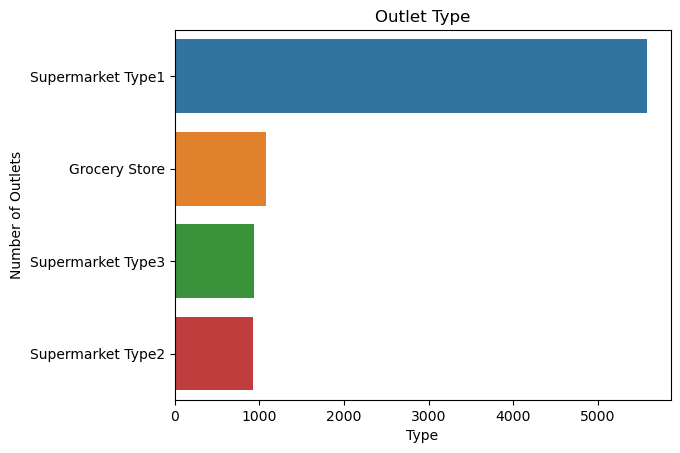

In [394]:
plotter.plot_countplot_horizontal(train_data, 'Outlet_Type', 'Outlet Type', 'Type', 'Number of Outlets')

From above plot, we can see that most of outlets exist are from type Supermarket Type1.

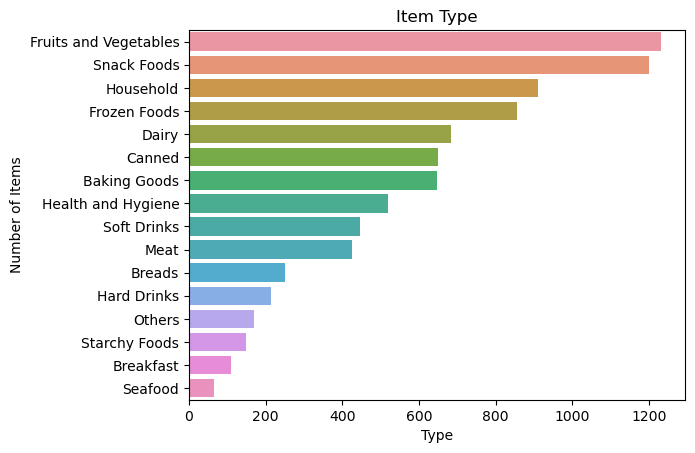

In [395]:
plotter.plot_countplot_horizontal(train_data, 'Item_Type', 'Item Type', 'Type', 'Number of Items')

From the above plot, we can see that most of items are sell in outlets are snack foods, fruits and vegetables.

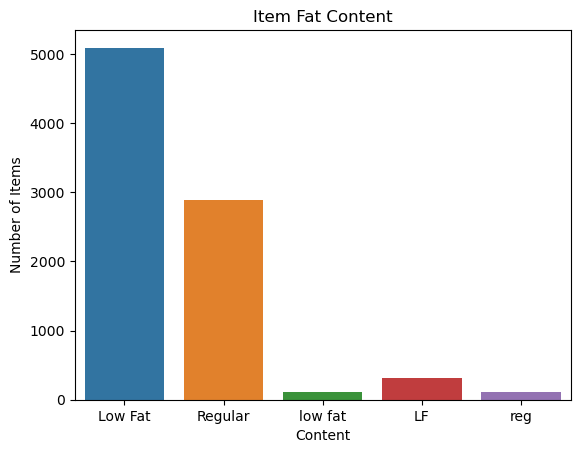

In [396]:
plotter.plot_countplot(train_data, "Item_Fat_Content", "Item Fat Content", "Content", "Number of Items")

From above we see that, Item_Fat_Content column has some inconsistency in values. which are low Fat, LF, low fat refer to same category and Regular and reg refer to same category. So we will fix this issue.

In [397]:
train_data['Item_Fat_Content'] = train_data['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'})

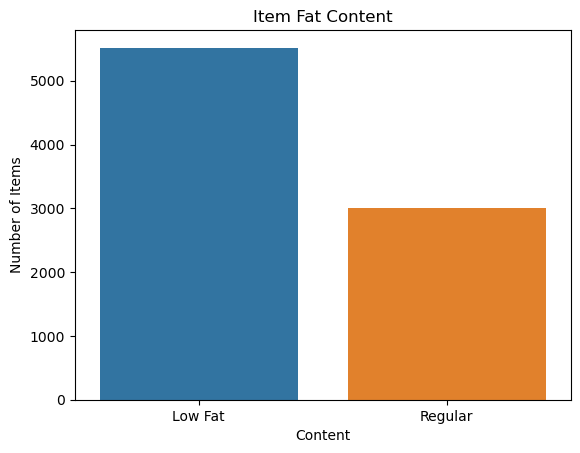

In [398]:
plotter.plot_countplot(train_data, "Item_Fat_Content", "Item Fat Content", "Content", "Number of Items")

From the above plot, we can see that the Fat Content of most of items are low Fat and Regular.

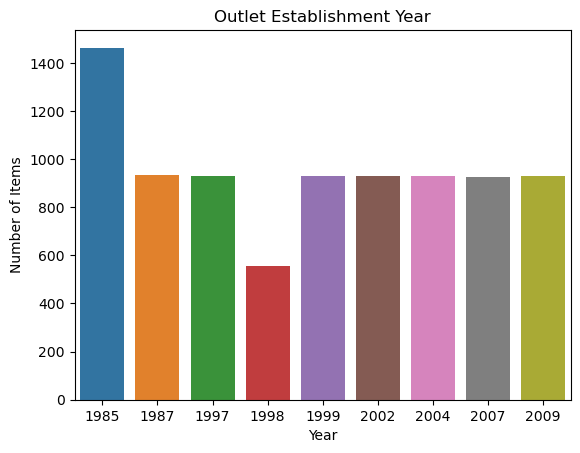

In [399]:
plotter.plot_countplot(train_data, "Outlet_Establishment_Year", "Outlet Establishment Year", "Year", "Number of Items")

It seems that the outlets built on 1985 have more items than any other outlets. Likewise, the outlets built on 1998 have less items.

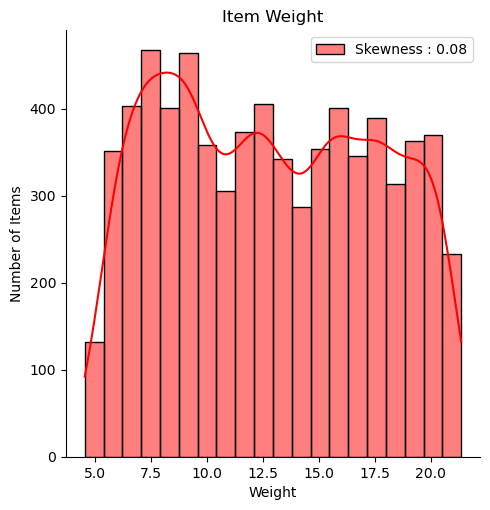

In [400]:
plotter.plot_displot(train_data, 'Item_Weight', 'Item Weight', 'Weight', 'Number of Items')

From above we can see that, most of items weight is between 10 to 15.

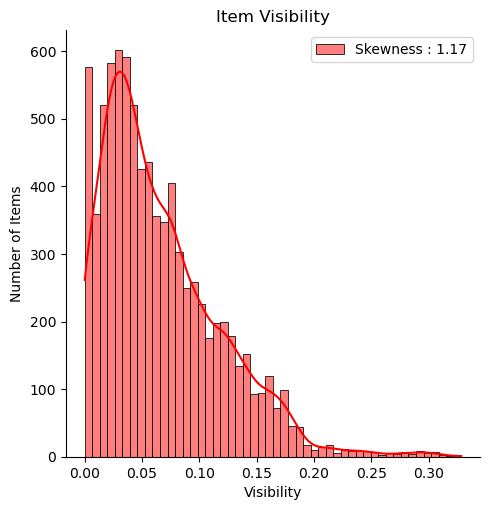

In [401]:
plotter.plot_displot(train_data, 'Item_Visibility', 'Item Visibility', 'Visibility', 'Number of Items')

From above we can see that, most of items have visibility between 0.05 to 0.15.

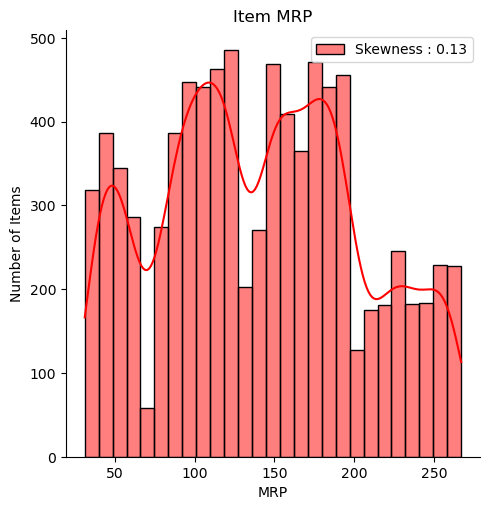

In [402]:
plotter.plot_displot(train_data, 'Item_MRP', 'Item MRP', 'MRP', 'Number of Items')

From above plot we can see that, most of items have MRP between 100 to 200.

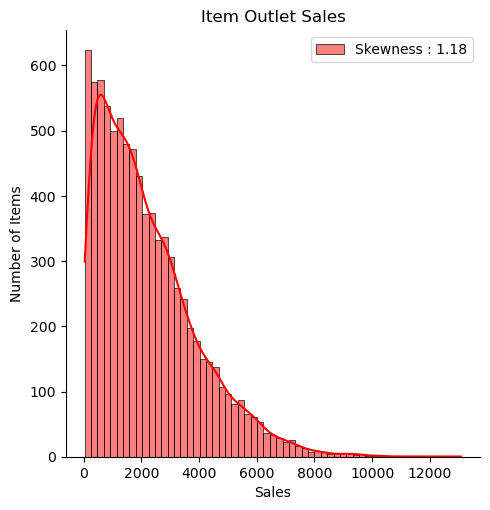

In [403]:
plotter.plot_displot(train_data, 'Item_Outlet_Sales', 'Item Outlet Sales', 'Sales', 'Number of Items')

From the above plot, we can see that the target variable is skewed to the right. We will need to transform it to make it more normally distributed.

## Exploratory Data Analysis

In [404]:
# check for duplicate rows in the data
print("There are {} duplicate rows in the data".format(train_data.duplicated().sum()))

There are 0 duplicate rows in the data


## Missing Value Treatment

#### Helper Missing Values Class

In [405]:
class MissingValues():
    def __init__(self, categorical_imputer, numerical_imputer):
        self.categorical_imputer = categorical_imputer
        self.numerical_imputer = numerical_imputer
        
    def plot_missing_values(self, data):
        """
        This function plots a bar chart for the missing values in each column of a given data frame

        Parameters:
        data (dataframe): the dataframe to be used

        Returns:
        None
        """
        plt.title("Missing Values")
        data.isnull().sum().plot(kind='bar')
        plt.xlabel("Columns")
        plt.ylabel("Number of missing values")
        plt.show()

    def count_missing_values(self, data):
        """
        This function counts the number of missing values in each column of a given data frame

        Parameters:
        data (dataframe): the dataframe to be used

        Returns:
        number of missing values in each column
        """
        return data.isnull().sum()
    
    def impute_categorical(self, data, column_name, data_type):
        """
        This function imputes the missing values in a given column with the mode of that column

        Parameters:
        data (dataframe): the dataframe to be used
        column_name (string): the name of the column to be imputed
        data_type (string): the type of the data, either 'train' or 'test'

        Returns:
        data (dataframe): the dataframe after imputing the missing values
        """
        if data_type == 'train':
            self.categorical_imputer.fit(data[[column_name]])
            data[column_name] = self.categorical_imputer.transform(data[[column_name]])
        elif data_type == 'test':
            data[column_name] = self.categorical_imputer.transform(data[[column_name]])
        return data

    def impute_numerical(self, data, column_name, data_type):
        """
        This function imputes the missing values in a given column with the mean of that column

        Parameters:
        data (dataframe): the dataframe to be used
        column_name (string): the name of the column to be imputed
        data_type (string): the type of the data, either 'train' or 'test'

        Returns:
        data (dataframe): the dataframe after imputing the missing values
        """
        if data_type == 'train':
            self.numerical_imputer.fit(data[[column_name]])
            data[column_name] = self.numerical_imputer.transform(data[[column_name]])
        elif data_type == 'test':
            data[column_name] = self.numerical_imputer.transform(data[[column_name]])
        return data

In [406]:
categorical_imputer = SimpleImputer(strategy='most_frequent')
numerical_imputer = SimpleImputer(strategy='mean')
missing_values = MissingValues(categorical_imputer, numerical_imputer)

In [407]:
missing_values.count_missing_values(train_data)

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

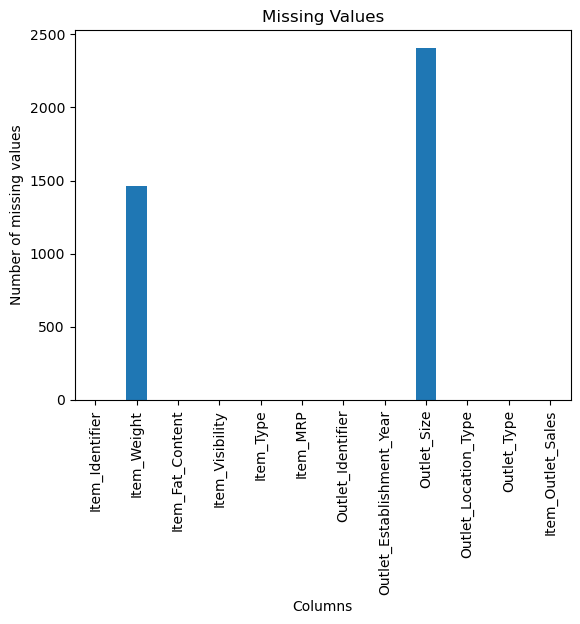

In [408]:
missing_values.plot_missing_values(train_data)

Now we have two columns that have missing values which are:
1. Item_Weight
2. Outlet_Size

One of them is categorical and the other is numerical. We will fill the missing values in Item_Weight with the mean of the column and the missing values in Outlet_Size with the mode of the column.

In [409]:
train_data = missing_values.impute_categorical(train_data, 'Outlet_Size', 'train')
train_data = missing_values.impute_numerical(train_data, 'Item_Weight', 'train')

#### Helper Outliers Class

In [410]:
class Outliers():
    def __init__(self):
        pass

    def plot_outliers(self, data, column_name):
        """
        This function plots a box plot for each column in a given data frame

        Parameters:
        data (dataframe): the dataframe to be used

        Returns:
        None
        """
        plt.title(column_name)
        sns.boxplot(data[column_name])
        plt.show()
    
    def remove_outliers(self, data, column_name):
        """
        This function removes the outliers in a given column in a given data frame

        Parameters:
        data (dataframe): the dataframe to be used
        column_name (string): the name of the column to be used

        Returns:
        None
        """
        q1 = data[column_name].quantile(0.25)
        q3 = data[column_name].quantile(0.75)
        iqr = q3 - q1
        data = data[~((data[column_name] < (q1 - 1.5 * iqr)) | (data[column_name] > (q3 + 1.5 * iqr)))]
        return data

Now we will see the outliers in each column

In [411]:
outliers = Outliers()

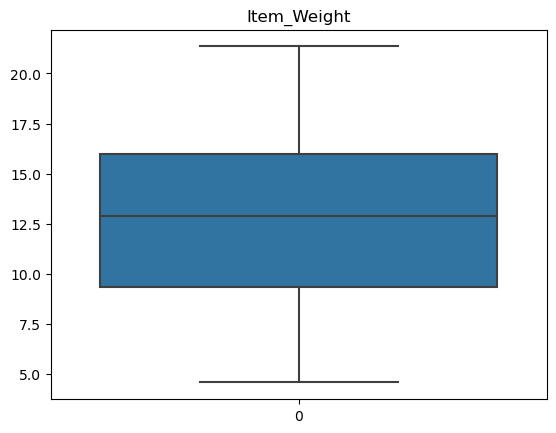

In [412]:
outliers.plot_outliers(train_data, 'Item_Weight')

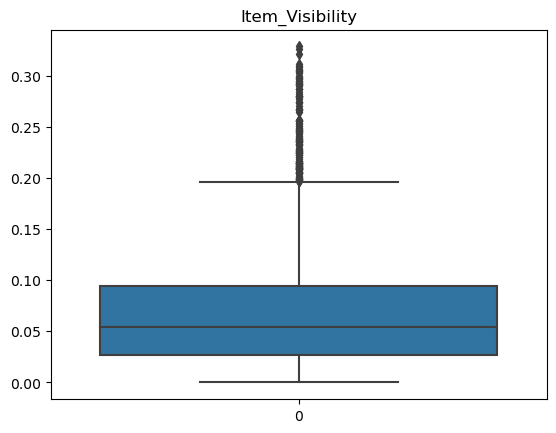

In [413]:
outliers.plot_outliers(train_data, 'Item_Visibility')

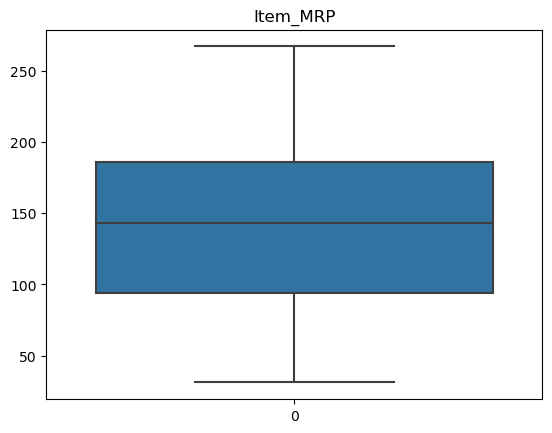

In [414]:
outliers.plot_outliers(train_data, 'Item_MRP')

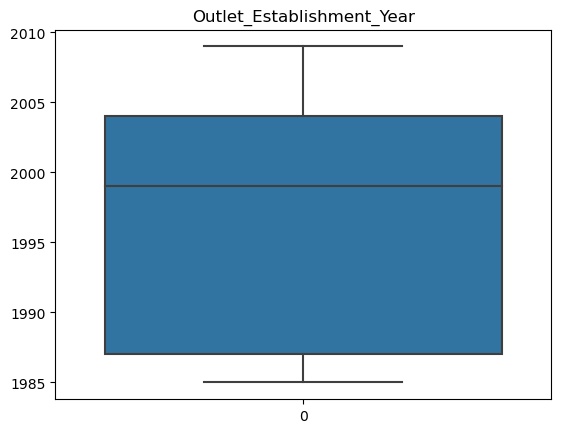

In [415]:
outliers.plot_outliers(train_data, 'Outlet_Establishment_Year')

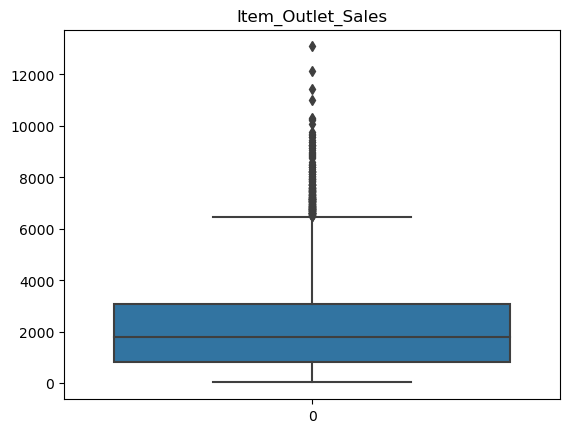

In [416]:
outliers.plot_outliers(train_data, 'Item_Outlet_Sales')

In [417]:
# remove the outliers from the data
train_data = outliers.remove_outliers(train_data, 'Item_Weight')
train_data = outliers.remove_outliers(train_data, 'Item_Visibility')
train_data = outliers.remove_outliers(train_data, 'Item_MRP')
train_data = outliers.remove_outliers(train_data, 'Outlet_Establishment_Year')
train_data = outliers.remove_outliers(train_data, 'Item_Outlet_Sales')

## Bivariate Analysis

## Feature Engineering

In this step we will remove unnecessary columns, create new columns.

Regarding Item_Visibility column, we saw that there are some items that have visibility 0 which is not possible. So we will replace these values with the mean of the column.

In [418]:
print("The percentage of zero items in the item visibility column is {:.2f}%".format((train_data['Item_Visibility'] == 0).sum() / train_data.shape[0] * 100))

The percentage of zero items in the item visibility column is 6.25%


In [419]:
train_data['Item_Visibility'] = train_data['Item_Visibility'].replace(0, train_data['Item_Visibility'].mean())

We can see that in Item_Identifier column, there is NC items which means Non-Consumable. and for theses items in the Item_Fat_Content column, the value is not Low Fat or Regular, it is Non-Consumable. So we will fix this issue.

In [421]:
train_data.loc[train_data['Item_Identifier'].str.startswith('NC'), 'Item_Fat_Content'] = 'Non-Consumable'

We will create new column which is Item_Type_Combined. This column will have 3 categories which are:
1. Food
2. Non-Consumable
3. Drinks

In [422]:
train_data['Item_Type_Combined'] = train_data['Item_Identifier'].apply(lambda x: x[0:2])
train_data['Item_Type_Combined'] = train_data['Item_Type_Combined'].map({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'})

We will create new column which is outlet_age. that will replace the establishment year of the outlet and calcualte number of years the outlet has been in operation till 2013.

In [423]:
train_data['Outlet_Age'] = 2013 - train_data['Outlet_Establishment_Year']

We can see that we don't need the Item_Identifier column as it is just a unique identifier for each item. Also, we don't need the Outlet_Identifier column as it is just a unique identifier for each outlet. So we will drop both of them. beside them we don't need outlet_Establishment_Year column as we have outlet_age column.

In [424]:
unnecessary_columns = ['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year']
train_data.drop(unnecessary_columns, axis=1, inplace=True)

## One Hot Encoding

Now for each of the categorical columns, we will apply one hot encoding to convert them into numerical columns.

In [426]:
categorical_columns = ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Type_Combined']
train_data = pd.get_dummies(train_data, columns=categorical_columns, drop_first=True)

In [427]:
train_data.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Outlet_Age,Item_Fat_Content_Non-Consumable,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Item_Type_Starchy Foods,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Type_Combined_Food,Item_Type_Combined_Non-Consumable
0,9.30,0.016047,249.8092,3735.1380,14,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
1,5.92,0.019278,48.2692,443.4228,4,0,1,0,0,0,...,0,1,0,0,1,0,1,0,0,0
2,17.50,0.016760,141.6180,2097.2700,14,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
3,19.20,0.063221,182.0950,732.3800,15,0,1,0,0,0,...,0,1,0,0,1,0,0,0,1,0
4,8.93,0.063221,53.8614,994.7052,26,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,1


## PreProcessing Data

In [428]:
# divide the data into features and target
X = train_data.drop('Item_Outlet_Sales', axis=1)
y = train_data[['Item_Outlet_Sales']]

Now we will scale the data using StandardScaler to make the data normally distributed.

In [429]:
scaler = StandardScaler()
numerical_colums = ['Item_Weight', 'Item_Visibility', 'Item_MRP'] 
scaler.fit(X[numerical_colums])
X[numerical_colums] = scaler.transform(X[numerical_colums])

In [430]:
# divide the train data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.1)

## Modeling

In [445]:
# load the test data
X_test = pd.read_csv('Test.csv')

In [446]:
X_test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


#### Helper Test Data Cleaner Class

In [447]:
class TestCleaner():
    def __init__(self, categorical_columns, numerical_colums, scaler):
        self.categorical_columns = categorical_columns
        self.numerical_colums = numerical_colums
        self.scaler = scaler
    
    def _fill_missing_values(self, data, categorical_col, numerical_col):
        """
        This function fills the missing values in the categorical and numerical columns of a given data frame

        Parameters:
        data (dataframe): the dataframe to be used
        categorical_col (string): the name of the categorical column to be imputed
        numerical_col (string): the name of the numerical column to be imputed

        Returns:
        data (dataframe): the dataframe after imputing the missing values
        """
        data = missing_values.impute_categorical(data, categorical_col, 'test')
        data = missing_values.impute_numerical(data, numerical_col, 'test')
        return data
    
    def _remove_outliers(self, data, column_names):
        """
        This function removes the outliers in the given columns of a given data frame

        Parameters:
        data (dataframe): the dataframe to be used
        column_names (list): the names of the columns to be used

        Returns:
        data (dataframe): the dataframe after removing the outliers
        """
        data = outliers.remove_outliers(data, column_names[0])
        data = outliers.remove_outliers(data, column_names[1])
        data = outliers.remove_outliers(data, column_names[2])
        data = outliers.remove_outliers(data, column_names[3])
        return data

    def _encode_categorical(self, data):
        """
        This function encodes the categorical columns of a given data frame

        Parameters:
        data (dataframe): the dataframe to be used

        Returns:
        data (dataframe): the dataframe after encoding the categorical columns
        """
        data = pd.get_dummies(data, columns=self.categorical_columns, drop_first=True)
        return data
    
    def _scale_data(self, data):
        """
        This function scales the numerical columns of a given data frame

        Parameters:
        data (dataframe): the dataframe to be used

        Returns:
        data (dataframe): the dataframe after scaling the numerical columns
        """
        data[self.numerical_colums] = self.scaler.transform(data[self.numerical_colums])
        return data
    
    def _feature_engineering(self, data):
        """
        This function performs feature engineering on a given data frame

        Parameters:
        data (dataframe): the dataframe to be used

        Returns:
        data (dataframe): the dataframe after performing feature engineering
        """
        data['Item_Visibility'] = data['Item_Visibility'].replace(0, data['Item_Visibility'].mean())
        data.loc[data['Item_Identifier'].str.startswith('NC'), 'Item_Fat_Content'] = 'Non-Consumable'
        data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
        data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'})
        data['Outlet_Age'] = 2013 - data['Outlet_Establishment_Year']
        unnecessary_columns = ['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year']
        data.drop(unnecessary_columns, axis=1, inplace=True)
        data.reset_index(drop=True, inplace=True)
            
    def clean_data(self, data):
        """
        This function cleans a given data frame

        Parameters:
        data (dataframe): the dataframe to be used

        Returns:
        data (dataframe): the dataframe after cleaning
        """
        data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'})
        categorical_col = 'Outlet_Size'
        numerical_col = 'Item_Weight'
        data = self._fill_missing_values(data, categorical_col, numerical_col)
        outliers_cols = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']
        data = self._remove_outliers(data, outliers_cols)
        data = self._feature_engineering(data)
        data = self._encode_categorical(data)
        data = self._scale_data(data)
        return data

In [448]:
test_cleaner = TestCleaner(categorical_columns, numerical_colums, scaler)

In [449]:
# apply the same preprocessing steps on the test data
X_test = test_cleaner.clean_data(X_test)
submission_df = pd.DataFrame({'Item_Identifier': X_test['Item_Identifier'], 'Outlet_Identifier': X_test['Outlet_Identifier']})

C:\Users\mahmo\AppData\Local\Temp\ipykernel_20380\2506800676.py:50: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data = pd.get_dummies(data, columns=self.categorical_columns, drop_first=True)


TypeError: object of type 'NoneType' has no len()

In [126]:
X_test.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,...,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,1.848273,-1.202551,-0.507727,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
1,-1.069658,-0.535707,-0.841573,1,0,0,0,1,0,0,...,0,0,0,1,0,1,0,1,0,0
2,0.406886,0.785482,1.668215,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,-1.300514,-1.033510,0.258886,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,0,0
4,-0.001473,1.196536,1.545942,1,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,1


We can notice that test data has no target column

#### Helper Trainer Class

In [102]:
class Trainer():
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test 
        self.y_test = y_test

    def train_model(self, model):
        """
        This function trains a given model and calculates the MSE on test data

        Parameters:
        model: the model to be trained
        X_train (dataframe): the training data
        y_train (dataframe): the training target
        X_test (dataframe): the test data
        y_test (dataframe): the test target

        Returns:
        MSE on test data
        """
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        return mean_squared_error(self.y_test, y_pred), mean_absolute_error(self.y_test, y_pred), r2_score(self.y_test, y_pred)
    
    def plot_MSE(self, MSE_values):
        """
        This function plots the MSE values for different models

        Parameters:
        MSE_values (list): a list of MSE values

        Returns:
        None
        """
        plt.bar(['Linear Regression', 'Lasso', 'Random Forest', 'XGBoost'], MSE_values)
        plt.title("MSE Values")
        plt.xlabel("Models")
        plt.ylabel("MSE")
        plt.show()
    
    def plot_MAE(self, MAE_values):
        """
        This function plots the MAE values for different models

        Parameters:
        MAE_values (list): a list of MAE values

        Returns:
        None
        """
        plt.bar(['Linear Regression', 'Lasso', 'Random Forest', 'XGBoost'], MAE_values)
        plt.title("MAE Values")
        plt.xlabel("Models")
        plt.ylabel("MAE")
        plt.show()
    
    def plot_R2(self, R2_values):
        """
        This function plots the R2 values for different models

        Parameters:
        R2_values (list): a list of R2 values

        Returns:
        None
        """
        plt.bar(['Linear Regression', 'Lasso', 'Random Forest', 'XGBoost'], R2_values)
        plt.title("R2 Values")
        plt.xlabel("Models")
        plt.ylabel("R2")
        plt.show()
    
    def models_metrics(self, mse_values, mae_values, r2_values):
        """
        This function calculates the MSE, MAE, and R2 values for different models

        Parameters:
        mse_values (list): a list of MSE values
        mae_values (list): a list of MAE values
        r2_values (list): a list of R2 values

        Returns:
        None
        """
        models = ['Linear Regression', 'Lasso', 'Random Forest', 'XGBoost']
        metrics = pd.DataFrame({'Model': models, 'MSE': mse_values, 'MAE': mae_values, 'R2': r2_values})
        # give points to the model that is best in each metric, then choose the model that has the highest points
        metrics['Points'] = metrics['MSE'].apply(lambda x: 1 if x == metrics['MSE'].min() else 0)
        metrics['Points'] += metrics['MAE'].apply(lambda x: 1 if x == metrics['MAE'].min() else 0)
        metrics['Points'] += metrics['R2'].apply(lambda x: 1 if x == metrics['R2'].max() else 0)
        best_model = metrics[metrics['Points'] == metrics['Points'].max()]['Model'].values[0]
        metrics.drop('Points', axis=1, inplace=True)
        return metrics, best_model

In this stage we will use different Machine Learning algorithms to predict the sales of each product at a particular store. We will use the following algorithms:
1. Linear Regression
2. Regularized Linear Regression
3. Random Forest
4. XGBoost

In [103]:
linear_regression = LinearRegression()
regularized_lr = Lasso()
random_forest = RandomForestRegressor()
xgb_regressor = xgb.XGBRegressor()

Now we will use the above Machine Learning algorithms with the default parameters to train the model and the algorithm that gives the best accuracy will be used for further tuning.

In [104]:
trainer = Trainer(X_train, y_train.values, X_val, y_val.values)

In [105]:
models = [linear_regression, regularized_lr, random_forest, xgb_regressor]
mse_values = []
mae_values = []
r2_values = []
for model in models:
    mse_value, mae_value, r2_value = trainer.train_model(model)
    mse_values.append(mse_value)
    mae_values.append(mae_value)
    r2_values.append(r2_value)

C:\Users\mahmo\AppData\Local\Temp\ipykernel_20380\2693005879.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(self.X_train, self.y_train)


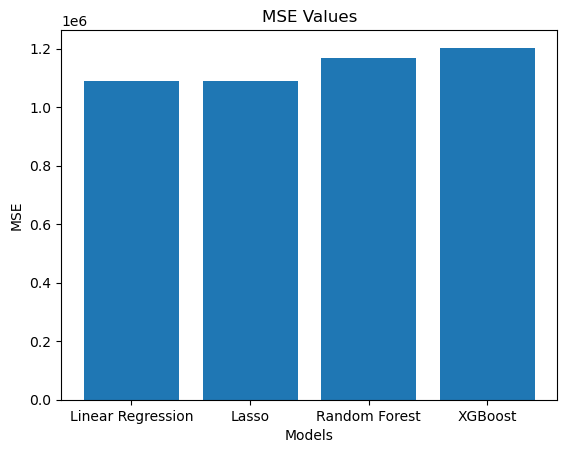

In [106]:
trainer.plot_MSE(mse_values)

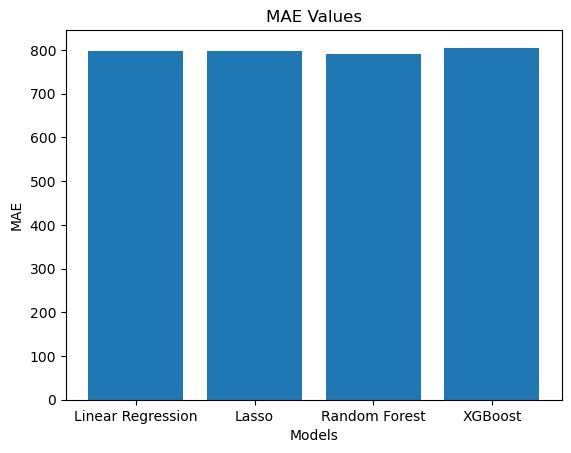

In [107]:
trainer.plot_MAE(mae_values)

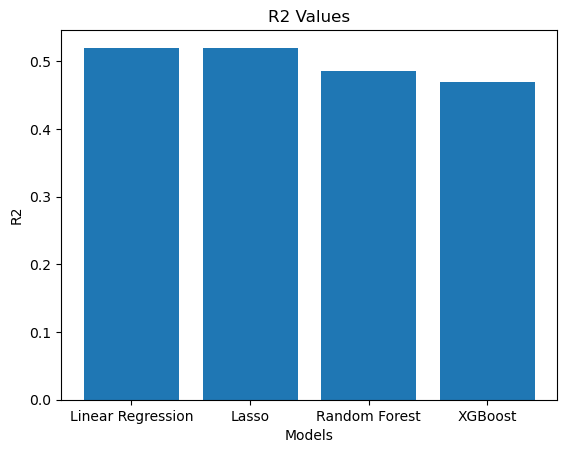

In [108]:
trainer.plot_R2(r2_values)

In [109]:
metrics , best_model = trainer.models_metrics(mse_values, mae_values, r2_values)

In [110]:
metrics

,Model,MSE,MAE,R2
0,Linear Regression,1.090634e+06,797.822351,0.519811
1,Lasso,1.089956e+06,797.662559,0.520110
2,Random Forest,1.169585e+06,791.815024,0.485051
3,XGBoost,1.203638e+06,805.153735,0.470057


In [111]:
best_model

'Lasso'

After initial training we have come out with the following:
1. We calculate the MSE, MAE and R2 on the validation set. The model that acheives the best combination of these metrics will be used for further tuning which is **Lasso**.
2. We will use GridSearchCV to find the best parameters for the best algorithm.

In [112]:
# write grid seatch model for lasso model above only
grid_params = {'alpha': [0.1, 0.5, 0.8, 1, 2, 5, 10, 20]}
grid_search = GridSearchCV(regularized_lr, grid_params, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'alpha': 2}

In [113]:
grid_search.best_score_

-1012674.4180017055

In [114]:
# final training for lasso with best params
regularized_lr_tuned = Lasso(alpha=grid_search.best_params_['alpha'])
mse_value, mae_value, r2_value = trainer.train_model(regularized_lr_tuned)
print("The metrics for the tuned Lasso model are:")
print("MSE: {}".format(mse_value))
print("MAE: {}".format(mae_value))
print("R2: {}".format(r2_value))

The metrics for the tuned Lasso model are:
MSE: 1089944.5182686003
MAE: 797.5836479625399
R2: 0.52011492390273


In [127]:
preds = regularized_lr_tuned.predict(X_test)
submission_df['Item_Outlet_Sales'] = preds
submission_df

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1783.342349
1,FDW14,OUT017,1486.872888
2,NCN55,OUT010,1811.525135
3,FDQ58,OUT017,2455.296003
4,FDY38,OUT027,4581.005310
...,...,...,...
5676,FDB58,OUT046,2316.449762
5677,FDD47,OUT018,2400.620229
5678,NCO17,OUT045,1926.880394
5679,FDJ26,OUT017,3371.578215


In [128]:
submission_df.to_csv('submission.csv', index=False)

## Summary